# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
!pip install -r requirement.txt

    100% |████████████████████████████████| 17.7MB 1.6MB/s eta 0:00:01  1% |▍                               | 235kB 15.6MB/s eta 0:00:02    7% |██▌                             | 1.4MB 25.2MB/s eta 0:00:01    20% |██████▋                         | 3.7MB 25.6MB/s eta 0:00:01    55% |█████████████████▊              | 9.8MB 25.0MB/s eta 0:00:01    61% |███████████████████▋            | 10.8MB 21.4MB/s eta 0:00:01    67% |█████████████████████▌          | 11.9MB 23.1MB/s eta 0:00:01    80% |█████████████████████████▋      | 14.1MB 23.6MB/s eta 0:00:01    86% |███████████████████████████▊    | 15.3MB 21.8MB/s eta 0:00:01
    100% |████████████████████████████████| 716kB 12.5MB/s ta 0:00:01
    100% |████████████████████████████████| 2.0MB 9.0MB/s eta 0:00:01    71% |██████████████████████▊         | 1.4MB 22.8MB/s eta 0:00:01
    100% |████████████████████████████████| 6.8MB 3.2MB/s eta 0:00:01    10% |███▎                            | 696kB 18.5MB/s eta 0:00:01
    100% |███████████████████

Failed to build xgboost
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Running setup.py install for xgboost ... done
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator

from helper import *

import xgboost as xgb
import lightgbm as lgb

import joblib

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [ ]:
# Save to pickle
azdias.to_pickle('azdias.pkl')
#customers.to_pickle('customers.pkl')

In [2]:
# Load Pickle Data
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

In [3]:
# Clean data by dropping missing values
print('General(orig) rows, cols: ', azdias.shape)
print('Customer(orig) rows, cols: ', customers.shape)

#azdias_clean = azdias.dropna(axis=0)
#customers_clean = customers.dropna(axis=0)

#print('General(clean) rows, cols: ', azdias_clean.shape)
#print('Customer(clean) rows, cols: ', customers_clean.shape)

General(orig) rows, cols:  (891221, 366)
Customer(orig) rows, cols:  (191652, 369)


In [4]:
# Loading feature values mapping files
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
dias['Attribute'] = dias['Attribute'].ffill()
dias.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [ ]:
#azdias_pre_cleanup = azdias.copy()
#customers_pre_cleanup = customers.copy()

In [5]:
# drop index and extra columns
azdias.drop(['LNR'], axis = 1, inplace = True)
customers.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis = 1, inplace = True)
print('General(dropped) rows, cols: ', azdias.shape)
print('Customer(dropped) rows, cols: ', customers.shape)

General(dropped) rows, cols:  (891221, 365)
Customer(dropped) rows, cols:  (191652, 365)


In [6]:
azdias_pre_cleanup_nans = azdias.isnull().sum().sum()
customers_pre_cleanup_nans = customers.isnull().sum().sum()

In [7]:
print('General missing value before clean-up: ' + str(azdias_pre_cleanup_nans))
print('Customer missing value before clean-up: ' + str(customers_pre_cleanup_nans))

General missing value before clean-up: 33492923
Customer missing value before clean-up: 13864522


In [ ]:
# unique values in data per column
for col in azdias.columns:
    print(col, azdias[col].unique())          
 

### Convert Special Characters to NaN

In [6]:
def convert_special_char_to_nan(df): # This function was later moved to helper.py file
    """ Convert special character to np.nan
    """
    special_chars = ['X', 'XX', ' ', '']
    columns_list = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015' ]
    for col in columns_list:
        df[col].replace(special_chars, np.nan, inplace=True)
    

In [7]:
convert_special_char_to_nan(azdias)
convert_special_char_to_nan(customers)

In [10]:
print('General missing value before clean-up: ' + str(azdias_pre_cleanup_nans) 
      + ' after: ' + str(azdias.isnull().sum().sum()))
print('Customer missing value before clean-up: ' + str(customers_pre_cleanup_nans) 
      + ' after: ' + str(customers.isnull().sum().sum()))

General missing value before clean-up: 33492923 after: 33494042
Customer missing value before clean-up: 13864522 after: 13864900


### Convert unknown to missing values

In [8]:
def covert_unknown_to_nan(df, dias): # This function was later moved to helper.py file
    """ Convert unknown values like 0, -1, 9 to np.nan 
    """
    unknowns = dias['Meaning'].where(dias.Meaning.str.contains("unknown")).value_counts().index
    dias = dias[dias['Meaning'].isin(unknowns)]
    for row in dias.iterrows():
        missing_val = row[1]['Value']
        attr = row[1]['Attribute']
        if attr not in df: 
            continue
        if isinstance(missing_val, int):
            df[attr].replace(missing_val, np.nan, inplace=True)
        elif isinstance(missing_val, str):
            df[attr].replace(eval("["+missing_val+"]"), np.nan, inplace=True)  


In [9]:
covert_unknown_to_nan(azdias, dias)
covert_unknown_to_nan(customers, dias)

In [ ]:
print('General missing value before clean-up: ' + str(azdias_pre_cleanup_nans) 
      + ' after: ' + str(azdias.isnull().sum().sum()))
print('Customer missing value before clean-up: ' + str(customers_pre_cleanup_nans) 
      + ' after: ' + str(customers.isnull().sum().sum()))

General missing value before clean-up: 33492923 after: 37088636


In [10]:
# Save to pickle
customers.to_pickle('customers2.pkl')
azdias.to_pickle('azdias2.pkl')

### Remove columns with higher percentage of missing values

In [2]:
# Load Pickle Data
azdias = pd.read_pickle('azdias2.pkl')
customers = pd.read_pickle('customers2.pkl')

In [6]:
# dropping columns with too many missin
def percent_missing_df(df): # This function was later moved to helper.py file
    percent = df.isnull().sum()*100/len(df.index)
    new_df = pd.DataFrame({'percent': percent}, index=df.columns)
    return new_df

In [5]:
percent_missing_cust = percent_missing_df(customers)
percent_missing_az = percent_missing_df(azdias)

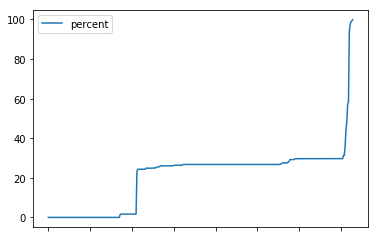

In [6]:
percent_missing_cust.sort_values(by=['percent']).plot()

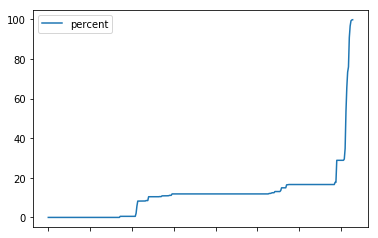

In [7]:
percent_missing_az.sort_values(by=['percent']).plot()

In [8]:
# Finding columns with missing values over 32 percent
columns_over_32_az = list(percent_missing_az[percent_missing_az['percent'] > 32].index)
columns_over_32_cust = list(percent_missing_cust[percent_missing_cust['percent'] > 32].index)

In [9]:
# deleting those columns common to both datasets
delete_columns = list(set(columns_over_32_az) & set(columns_over_32_cust))
delete_columns

['AGER_TYP',
 'ALTER_KIND2',
 'TITEL_KZ',
 'ALTER_KIND3',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'ALTER_KIND4',
 'EXTSEL992',
 'ALTER_HH',
 'ALTER_KIND1']

In [10]:
customers.drop(delete_columns, axis=1, inplace=True)
azdias.drop(delete_columns, axis=1, inplace=True)

In [11]:
# Save to pickle
customers.to_pickle('customers3.pkl')
azdias.to_pickle('azdias3.pkl')

### Feature Engineering

In [2]:
# Load Pickle Data
azdias = pd.read_pickle('azdias3.pkl')
#customers = pd.read_pickle('customers3.pkl')

In [12]:
numeric_columns = customers.select_dtypes(include=np.number).columns.tolist()
categorical_columns = list(set(customers.columns).difference(set(numeric_columns)))
categorical_columns

['CAMEO_DEU_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'OST_WEST_KZ',
 'EINGEFUEGT_AM']

In [13]:
for col in categorical_columns:
    print(col)
    print(customers[col].value_counts(dropna=False))

CAMEO_DEU_2015
NaN    50554
2D     11208
6B      9634
4C      9053
3D      8085
4A      7507
3C      6628
1D      5880
2C      5076
5D      4546
8A      4252
1A      4198
7A      4109
8B      3790
2A      3715
2B      3485
7B      3421
1E      3337
6E      3086
6C      2832
8C      2801
8D      2206
1C      2206
4D      2124
4B      2093
5A      1969
9D      1957
3A      1904
3B      1773
5B      1696
5C      1574
9E      1508
4E      1287
6D      1235
7C      1194
6F      1168
1B      1157
5F      1059
7E      1034
9A      1023
9C       987
9B       917
5E       822
7D       800
6A       762
Name: CAMEO_DEU_2015, dtype: int64
D19_LETZTER_KAUF_BRANCHE
NaN                       47697
D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE         

In [3]:
def feature_eng(df): # This function was later moved to helper.py file
    """ Feature Engineering
    """
    col_drop = []
    # label encoding CAMEO_DEU_2015 (one-hot encoding consumes a lot of memory because of too many unique labels)
    if 'CAMEO_DEU_2015' in df:
        print("label encoding CAMEO_DEU_2015")
        cameo_fill = df['CAMEO_DEU_2015'].value_counts().idxmax()
        df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].fillna(cameo_fill)
        data = np.array(df['CAMEO_DEU_2015'])
        encoder = LabelEncoder()
        encoded_values = encoder.fit_transform(data)
        df['CAMEO_DEU_2015'] = encoded_values
    
    if 'D19_LETZTER_KAUF_BRANCHE' in df:
        print("label encoding D19_LETZTER_KAUF_BRANCHE")
        letzer_fill = df['D19_LETZTER_KAUF_BRANCHE'].value_counts().idxmax()
        df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].fillna(letzer_fill)
        data = np.array(df['D19_LETZTER_KAUF_BRANCHE'])
        encoder = LabelEncoder()
        encoded_values = encoder.fit_transform(data)
        df['D19_LETZTER_KAUF_BRANCHE'] = encoded_values
    
    # Convert CAMEO_DEUG_2015 str to float
    if 'CAMEO_DEUG_2015' in df:
        print("Convert CAMEO_DEUG_2015 str to float")
        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: float(x))
    
    if 'OST_WEST_KZ' in df:
        
        # Mapping OST_WEST_KZ categorical
        # W = 1
        # O = 0
        print("Mapping OST_WEST_KZ categorical")
        ost_west_map = {'W': 0, 'O': 1}
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(ost_west_map)
                                                                            
    # Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
    if 'CAMEO_INTL_2015' in df:
        print("Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH")
        # WEALTH
        # 1: Wealthy Households
        # 2: Prosperous Households
        # 3: Comfortable Households
        # 4: Less Affluent Households
        # 5: Poorer Households
        df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(int(x), 10) if isinstance(x, str) else np.nan)
        # FAMILY
        # 1: Pre-Family Couples & Singles
        # 2: Young Couples With Children
        # 3: Families With School Age Children
        # 4: Older Families & Mature Couples
        # 5: Elders In Retirement
        df['FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(int(x), 10) if isinstance(x, str) else np.nan)
        col_drop.append('CAMEO_INTL_2015')
  
    # Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
    if 'LP_LEBENSPHASE_FEIN' in df:
        print("Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE")
        # INCOME
        # 1: low
        # 2: average
        # 3: wealthy
        # 4: top
        income_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 3,
                      11: 2, 12: 2, 13: 4, 14: 2, 15: 1, 16: 2, 17: 2, 18: 3, 19: 3, 20: 4,
                      21: 1, 22: 2, 23: 3, 24: 1, 25: 2, 26: 2, 27: 2, 28: 4, 29: 1, 30: 2,
                      31: 1, 32: 2, 33: 2, 34: 2, 35: 4, 36: 2, 37: 2, 38: 2, 39: 4, 40: 4}
        df['INCOME'] = df['LP_LEBENSPHASE_FEIN'].map(income_map)
        # AGE
        # 1: young
        # 2: middle
        # 3: advanced
        # 4: retirement
        age_map = {1: 1, 2: 2, 3: 1, 4: 2, 5: 3, 6: 4, 7: 3, 8: 4, 9: 2, 10: 2,
                  11: 3, 12: 4, 13: 3, 14: 1, 15: 3, 16: 3, 17: 2, 18: 1, 19: 3, 20: 3,
                  21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 1, 30: 1,
                  31: 3, 32: 3, 33: 1, 34: 1, 35: 1, 36: 3, 37: 3, 38: 4, 39: 2, 40: 4}
        df['AGE'] = df['LP_LEBENSPHASE_FEIN'].map(age_map)
        col_drop.append('LP_LEBENSPHASE_FEIN')
    
   
    # Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
    if 'PRAEGENDE_JUGENDJAHRE' in df:
        print("Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT")
        # DECADE
        decade_map = {1: 40, 2:40, 3: 50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 
                      11:80, 12:80, 13:80, 14:90, 15:90}
        df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
        # MOVEMENT
        # 0: Mainstream
        # 1: Avantgarde
        movement_map = {1: 0, 2:1, 3: 0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 
                      11:1, 12:0, 13:1, 14:0, 15:1}
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
        col_drop.append('PRAEGENDE_JUGENDJAHRE')

    if 'EINGEFUEGT_AM' in df:
        # Get just the registeration year
        print("Get the registeration year from EINGEFUEGT_AM")
        df['EINGEFUEGT_YEAR'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
        col_drop.append('EINGEFUEGT_AM')
    
    print("Dropping unwanted columns")
    df.drop(columns=col_drop, axis=1, inplace=True)
    
    print("Imputing missing values with most frequent value")
    #Impute the missing values with the most frequent value of the column
    imputer = Imputer(missing_values=np.nan, strategy='most_frequent')
    imputed_df = pd.DataFrame(imputer.fit_transform(df))
    imputed_df.columns = df.columns
    imputed_df.index = df.index
    
    return imputed_df

In [20]:
customer_eng = feature_eng(customers)

label encoding CAMEO_DEU_2015
label encoding D19_LETZTER_KAUF_BRANCHE
Convert CAMEO_INTL_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns
Imputing missing values with most frequent value


In [21]:
numeric_columns = customer_eng.select_dtypes(include=np.number).columns.tolist()
categorical_columns = list(set(customer_eng.columns).difference(set(numeric_columns)))
categorical_columns

[]

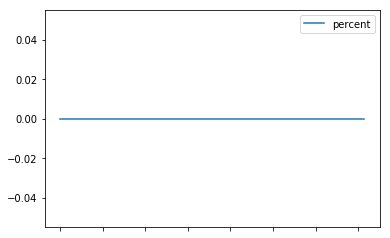

In [22]:
percent_missing_cust = percent_missing_df(customer_eng)
percent_missing_cust.plot()

In [25]:
customer_eng.to_pickle('customers_eng.pkl')

In [4]:
azdias_eng = feature_eng(azdias)

label encoding CAMEO_DEU_2015
label encoding D19_LETZTER_KAUF_BRANCHE
Convert CAMEO_INTL_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns
Imputing missing values with most frequent value


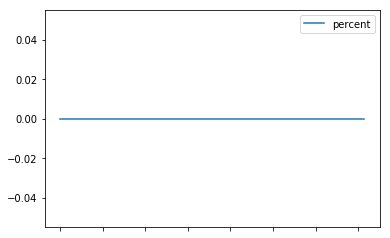

In [8]:
percent_missing_az = percent_missing_df(azdias_eng)
percent_missing_az.plot()

In [9]:
# Save to pickle

azdias_eng.to_pickle('azdias_eng.pkl')

### Feature Scaling

In [10]:
# Load Pickle Data
#azdias_eng = pd.read_pickle('azdias_eng.pkl')
customers_eng = pd.read_pickle('customers_eng.pkl')

In [11]:
def feature_scaling(df):
    """ Perform Min-Max Scaling
    """
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df))
    scaled_df.columns = df.columns
    scaled_df.index = df.index
    return scaled_df

In [12]:
customer_scaled = feature_scaling(customers_eng)
customer_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH,FAMILY,INCOME,AGE,DECADE,MOVEMENT,EINGEFUEGT_YEAR
0,0.0,0.40,0.001912,0.0,0.0,0.095238,0.002667,0.0,0.00,0.333333,...,0.4,0.0,0.375,0.00,0.50,1.000000,0.666667,0.2,1.0,0.0
1,1.0,0.40,0.001912,0.0,0.0,0.142857,0.002667,0.0,0.25,0.833333,...,0.4,0.0,0.375,0.25,0.75,0.333333,0.666667,0.2,0.0,0.0
2,0.0,0.00,0.001912,0.0,0.0,0.047619,0.002667,0.0,0.25,1.000000,...,0.4,1.0,0.375,0.50,0.75,1.000000,0.666667,0.2,1.0,0.0
3,0.0,0.32,0.000000,0.0,0.0,0.000000,0.002667,0.0,0.00,1.000000,...,0.0,0.0,0.375,0.25,0.75,0.333333,0.666667,0.0,0.0,0.0
4,0.0,0.56,0.013384,0.0,0.0,0.190476,0.018667,0.0,0.25,0.333333,...,0.0,0.0,0.250,0.75,0.00,0.000000,0.666667,0.6,0.0,0.0


In [86]:
customer_scaled.to_pickle('customers_scaled.pkl')

In [15]:
azdias_scaled = feature_scaling(azdias_eng)

### Dimensionality Reduction

In [2]:
# Load Pickle Data
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
customer_scaled = pd.read_pickle('customers_scaled.pkl')

In [3]:
def plot_pca_variance(df):
    """ Plot PCA Variance Graph
    """
    pca = PCA().fit(df)
    plt.figure(figsize=(10,8))
    plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
    plt.title("Exaplained Variance by Components")
    plt.xlabel("Number of Component")
    plt.ylabel("Cummulative Explained Variance")
    plt.grid()
    plt.show()
    

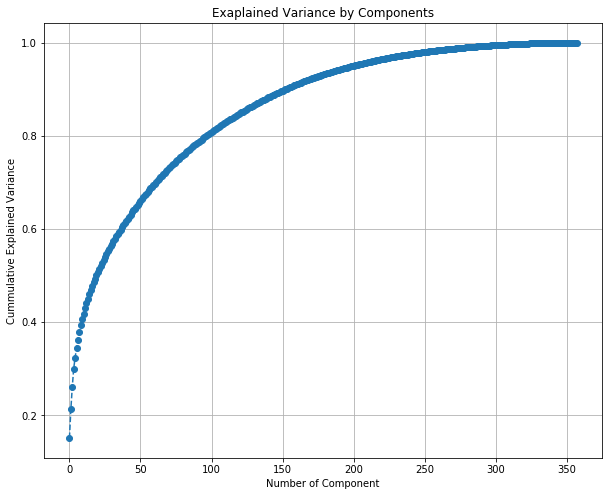

In [23]:
plot_pca_variance(customer_scaled)

In [ ]:
plot_pca_variance(azdias_scaled)

In [73]:
def pca_model(df, n):
    """ Get the PCA model to get the components
    """
    pca = PCA(n_components=n, random_state=87).fit(df)
    print('Explained Variance: ' + str(pca.explained_variance_ratio_.sum()))
    pca_components = pd.DataFrame(pca.components_,columns=df.columns, index=pca_df.columns)
    return pca, pca_components

In [74]:
def reduce_dimension(df, pca):
    """ Perform PCA transformation to reduce dimension
    """
    pca_df = pd.DataFrame(pca.transform(df))
    
    return pca_df, pca_components

Use the same PCA model for general poplation and customer data, so the principal components are the same, which is important for finding the customer segmentation later.

In [75]:
pca_150, pca_components = pca_model(azdias_scaled, 150)

Explained Variance: 0.889071884627


In [ ]:
azdias_reduced = reduce_dimension(azdias_scaled, pca_150)

In [77]:
customers_reduced = reduce_dimension(customer_scaled, pca_150)

### Component Makeup

In [78]:
def display_component(pca_components_df, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = len(pca_components_df)-component_num

    # match weights to features in scaled dataframe, using list comprehension
    comps = pd.DataFrame(list(zip(pca_components_df.iloc[row_idx], pca_components_df.columns.values)), 
                         columns=['weights', 'features'])
    
    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)
    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

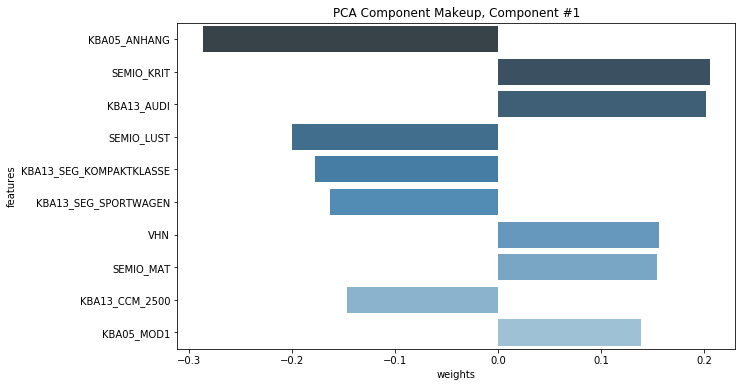

In [79]:
num=1
display_component(pca_components, component_num=num, n_weights=10)

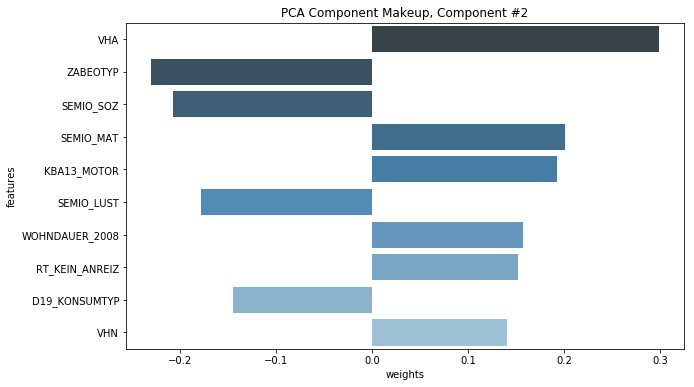

In [81]:
num=2
display_component(pca_components, component_num=num, n_weights=10)

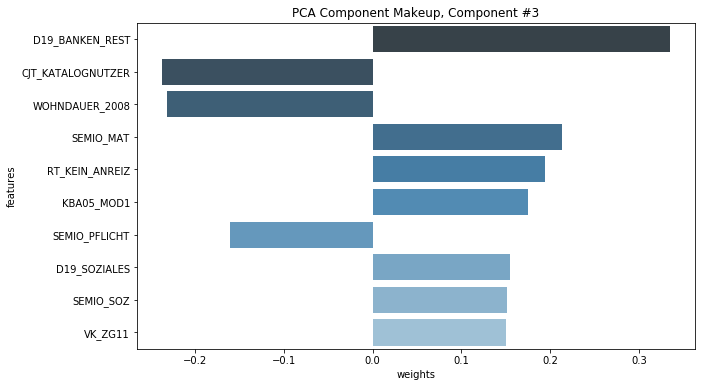

In [83]:
num=3
display_component(pca_components, component_num=num, n_weights=10)

In [84]:
# Save to pickle
customers_reduced.to_pickle('customers_reduced.pkl')

In [67]:
azdias_reduced.to_pickle('azdias_reduced.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Elbow Method

In [2]:
# Load Pickle Data
azdias_reduced = pd.read_pickle('azdias_reduced.pkl')
customers_reduced = pd.read_pickle('customers_reduced.pkl')

In [10]:
# K-Means Clustering
def elbow_method(scaled_features, max_clusters):
    """ elbow method to find the number of clusters
    """
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

    # A list holds the SSE values for each k
    sse = []
    for k in range(1, max_clusters):
        print("K: {}".format(k))
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        print("The lowest SSE value: {}".format(sse[k-1]))
    
    # Plot SSE vs number of clusters
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, max_clusters), sse)
    plt.xticks(range(1, max_clusters))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
        

K: 1
The lowest SSE value: 21326063.975148182
K: 2
The lowest SSE value: 19524489.31910475
K: 3
The lowest SSE value: 18714798.726486605
K: 4
The lowest SSE value: 18089666.508084763
K: 5
The lowest SSE value: 17616730.927996017
K: 6
The lowest SSE value: 17251321.233780053
K: 7
The lowest SSE value: 16980490.906085905
K: 8
The lowest SSE value: 16728569.284293624
K: 9
The lowest SSE value: 16547904.450586628
K: 10
The lowest SSE value: 16399465.343768438
K: 11
The lowest SSE value: 16266560.4063595
K: 12
The lowest SSE value: 16144582.81053339
K: 13
The lowest SSE value: 16032773.138720745
K: 14
The lowest SSE value: 15942851.12860372
K: 15
The lowest SSE value: 15862636.869239861
K: 16
The lowest SSE value: 15766717.309916541
K: 17
The lowest SSE value: 15680662.463771755
K: 18
The lowest SSE value: 15617241.180784734
K: 19
The lowest SSE value: 15537232.256807828


ValueError: x and y must have same first dimension, but have shapes (10,) and (19,)

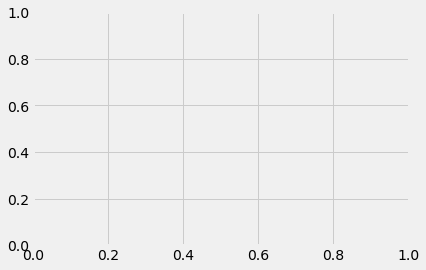

In [11]:
%%time
elbow_method(azdias_reduced, 20)

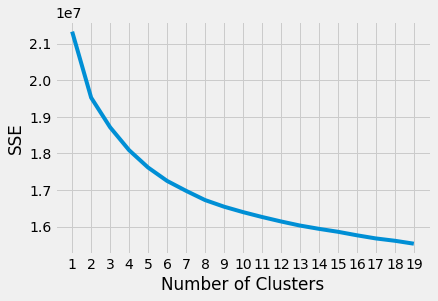

In [12]:
max_clusters = 20
sse = [21326063.975148182, 19524489.31910475, 18714798.726486605, 18089666.508084763, 17616730.927996017,
      17251321.233780053, 16980490.906085905, 16728569.284293624, 16547904.450586628, 16399465.343768438,
      16266560.4063595, 16144582.81053339, 16032773.138720745, 15942851.12860372, 15862636.869239861,
      15766717.309916541, 15680662.463771755, 15617241.180784734, 15537232.256807828]
# Plot SSE vs number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [13]:
# Number of Clusters
kl = KneeLocator(range(1, max_clusters), sse, curve="convex", direction="decreasing")
kl.elbow

6

### K-Means Clustering

In [14]:
# K-Means model for 6 clusters
kmeans = KMeans(6)
kmodel = kmeans.fit(azdias_reduced)

In [50]:
# Save Model
import pickle
pickle.dump(kmodel, open("kmodel.pkl", "wb"))

In [ ]:
# Load Model
kmodel = pickle.load(open("kmodel.pkl", "rb"))

In [48]:
len(kmodel.cluster_centers_[0])

150

In [18]:
azdias_clusters = kmodel.predict(azdias_reduced)

In [22]:
customers_clusters = kmodel.predict(customers_reduced)

### Cluster Mapping

In [30]:
# Cluster Frequency
from collections import Counter
azdias_counts = Counter(azdias_clusters)
customer_counts = Counter(customers_clusters)
azdias_freqs = {cluster: 100*(freq / len(azdias_clusters)) for cluster, freq in azdias_counts.items()}
customer_freqs = {cluster: 100*(freq / len(customers_clusters)) for cluster, freq in customer_counts.items()}

{1: 38.88975852065201,
 2: 23.8239100035481,
 4: 12.022833051572642,
 0: 2.0203285120948387,
 5: 21.818713084131655,
 3: 1.4244568280007512}

In [39]:
customer_freqs_df = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['Percentage'])
customer_freqs_df['Cluster'] = customer_freqs_df.index
customer_freqs_df['Type'] = 'Customer'
customer_freqs_df.head()

,Percentage,Cluster,Type
1,38.889759,1,Customer
2,23.823910,2,Customer
4,12.022833,4,Customer
0,2.020329,0,Customer
5,21.818713,5,Customer


In [40]:
azdias_freqs_df = pd.DataFrame.from_dict(azdias_freqs, orient='index', columns=['Percentage'])
azdias_freqs_df['Cluster'] = azdias_freqs_df.index
azdias_freqs_df['Type'] = 'General'
azdias_freqs_df.head()

,Percentage,Cluster,Type
5,8.863346,5,General
3,17.826555,3,General
1,18.509438,1,General
2,21.332756,2,General
4,17.446514,4,General


In [43]:
combined_cluster_dist = pd.concat([customer_freqs_df, azdias_freqs_df])

,Percentage,Cluster,Type
1,38.889759,1,Customer
2,23.823910,2,Customer
4,12.022833,4,Customer
0,2.020329,0,Customer
5,21.818713,5,Customer
3,1.424457,3,Customer
5,8.863346,5,General
3,17.826555,3,General
1,18.509438,1,General
2,21.332756,2,General


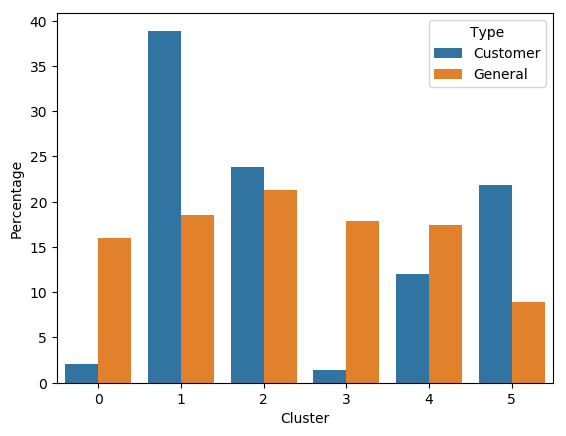

In [46]:
plt.style.use('default')
sns.barplot(x='Cluster', y='Percentage', hue='Type', data=combined_cluster_dist)
plt.show()

The above diagram shows that the general population data is quite evenly distributed among the 6 clusters but the customer data predominantly lies in the cluster **1, 2, 4** and **5**.

In [85]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


# Analysis of principal components of cluster 1 consisting of people with over-representation in the
# customer data compared to the general population.
p_comp_cluster_1 = pd.Series(kmodel.cluster_centers_[1])
p_comp_cluster_1.index = p_comp_cluster_1.index + 1
p_comp_cluster_1.sort_values(ascending=False, inplace=True)
p_comp_cluster_1

1      1.206334
5      0.203390
3      0.150229
8      0.090239
4      0.085845
10     0.060001
37     0.058471
33     0.057364
25     0.048626
36     0.036385
18     0.030618
38     0.029457
39     0.029054
51     0.024172
28     0.020577
11     0.020397
87     0.019455
21     0.017811
83     0.017040
46     0.016585
43     0.014917
35     0.014098
84     0.013824
44     0.013774
52     0.013718
14     0.012677
66     0.012421
101    0.012088
59     0.012034
15     0.011546
         ...   
134   -0.008796
148   -0.011226
50    -0.011491
111   -0.012095
71    -0.014218
26    -0.015298
110   -0.015520
56    -0.016239
107   -0.016860
30    -0.017131
45    -0.017967
54    -0.018663
22    -0.019086
47    -0.019152
24    -0.019478
19    -0.020634
58    -0.022007
29    -0.023406
34    -0.024478
20    -0.025312
31    -0.035577
23    -0.040305
13    -0.049762
16    -0.055305
17    -0.057454
27    -0.066945
12    -0.068946
9     -0.088116
6     -0.232375
2     -1.470122
Length: 150, dtype: floa

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Loading feature values mapping files
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
dias['Attribute'] = dias['Attribute'].ffill()

In [7]:
target = mailout_train['RESPONSE']
mailout_train.drop(['RESPONSE'], inplace=True, axis=1)
mailout_train.drop(['LNR'], inplace=True, axis=1)

In [8]:
mailout_train.shape

(42962, 365)

In [9]:
mailout_train_eng = preprocess(mailout_train, dias)

Dropping columns with high percentage of missing values ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
label encoding CAMEO_DEU_2015
Convert CAMEO_DEUG_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
Imputing missing values with most frequent value


In [10]:
mailout_train_scaled = feature_scaling(mailout_train_eng)

In [11]:
mailout_train_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH,FAMILY,INCOME,AGE,DECADE,MOVEMENT,EINGEFUEGT_YEAR
0,0.000,0.32,0.034247,0.0,0.0,0.041667,0.035230,0.0,0.250,0.666667,...,0.4,1.0,0.375,0.25,0.75,0.333333,1.000000,0.0,0.0,0.041667
1,0.375,0.52,0.002283,0.0,0.0,0.083333,0.002710,0.0,0.125,0.666667,...,0.0,1.0,0.250,0.25,0.75,0.666667,0.666667,0.6,0.0,0.250000
2,0.000,0.28,0.000000,0.0,0.0,0.000000,0.002710,0.0,0.375,0.000000,...,0.4,0.0,0.375,0.25,0.75,0.333333,0.666667,0.0,1.0,0.166667
3,0.000,0.24,0.009132,0.0,0.0,0.083333,0.010840,0.0,0.375,0.166667,...,0.4,1.0,0.375,0.25,0.75,0.333333,0.666667,0.0,1.0,0.041667
4,0.000,0.36,0.121005,0.0,0.0,0.041667,0.119241,0.0,0.250,0.500000,...,0.4,0.0,0.250,0.25,0.75,0.333333,0.333333,0.2,0.0,0.041667


In [12]:
mailout_train_scaled.shape

(42962, 357)

### Modeling

In [15]:
lgb_model = lgb.LGBMClassifier(application='binary', learning_rate=0.2952150312099677,
               max_bin=1579, max_depth=2, metric='auc', min_child_samples=50,
               n_estimators=20, num_leaves=114, reg_alpha=1.0,
               reg_lambda=6.087536046756808e-07, scale_pos_weight=1,
               verbose=-1)

In [16]:
lgb_model.fit(mailout_train_scaled, target)

LGBMClassifier(application='binary', learning_rate=0.2952150312099677,
               max_bin=1579, max_depth=2, metric='auc', min_child_samples=50,
               n_estimators=20, num_leaves=114, reg_alpha=1.0,
               reg_lambda=6.087536046756808e-07, scale_pos_weight=1,
               verbose=-1)

In [17]:
def plot_feature_importance(model, features, n=10):
    """ Plot n number of features from the model
    """
    sorted_idx = model.feature_importances_.argsort()
    df = pd.DataFrame()
    df['features'] = features
    df['importance'] = model.feature_importances_
    df_sorted = df.sort_values('importance', ascending=False)
    df_sorted[:n].plot.barh(x='features', y='importance')
    plt.xlabel("LGBM Feature Importance")
    

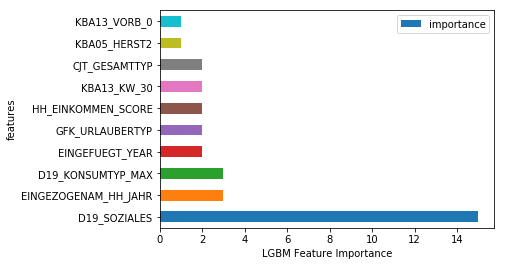

In [19]:
plot_feature_importance(lgb_model, mailout_train_scaled.columns.values, n=10)

In [20]:
lgb_model.feature_importances_

array([ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,
        0,  0,  0,  0,  1,  0,  0,  0,  1, 15,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  3,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        2,  0,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [12]:
mailout_train_scaled.shape

(42962, 358)

In [10]:
bayes_lgbm = lgb.LGBMClassifier(application='binary', colsample_bytree=0.9, learning_rate=0.25,
               max_bin=1000, max_depth=2, metric='auc', min_child_samples=1,
               n_estimators=40, num_leaves=20, reg_alpha=10.0, reg_lambda=1e-10,
               scale_pos_weight=1, verbose=-1)

In [12]:
bayes_lgbm.fit(mailout_train_scaled, target)

LGBMClassifier(application='binary', colsample_bytree=0.9, learning_rate=0.25,
               max_bin=1000, max_depth=2, metric='auc', min_child_samples=1,
               n_estimators=40, num_leaves=20, reg_alpha=10.0, reg_lambda=1e-10,
               scale_pos_weight=1, verbose=-1)

In [13]:
# save model
joblib.dump(bayes_lgbm, 'lgb_01.pkl')

['lgb_01.pkl']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [2]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Loading feature values mapping files
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
dias['Attribute'] = dias['Attribute'].ffill()

In [4]:
lnr = pd.DataFrame(mailout_test['LNR'].astype('int32'))

In [5]:
mailout_test.drop(['LNR'], inplace=True, axis=1)
mailout_test_eng = preprocess(mailout_test, dias)
mailout_test_scaled = feature_scaling(mailout_test_eng)

Dropping columns with high percentage of missing values ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
label encoding CAMEO_DEU_2015
label encoding D19_LETZTER_KAUF_BRANCHE
Convert CAMEO_DEUG_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
Imputing missing values with most frequent value


In [14]:
# Applying the same scaler from trained data to test
scaler = MinMaxScaler().fit(mailout_train_eng)
mailout_test_scaled = scaler.transform(mailout_test_eng)

In [15]:
# load model
lgbm_model = joblib.load('lgbm_200.pkl')
predictions = lgbm_model.predict_proba(mailout_test_scaled)[:,1]

In [16]:
response_df = pd.DataFrame(predictions, columns =['RESPONSE'])
submission_df = pd.concat([lnr, response_df], axis=1)
submission_df.set_index('LNR', inplace = True)

In [17]:
submission_df.shape

(42833, 1)

In [18]:
submission_df.to_csv("Avrato_kaggle_submission_lgbm_200_2.csv")